In [ ]:
import pandas as pd
from collections import defaultdict, Counter
import re

# Load the dataset
data = pd.read_csv('IMDB.csv')

# Tokenize the dataset
def tokenize(text):
    text = re.sub(r'<br\s*/><br\s*/>', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().split()

# Count bigrams in the dataset
def count_bigrams(reviews):
    bigram_counts = defaultdict(Counter)
    for review in reviews:
        tokens = tokenize(review)
        for i in range(len(tokens) - 1):
            bigram_counts[tokens[i]][tokens[i + 1]] += 1
    return bigram_counts

# Calculate bigram probabilities
def bigram_probability(bigram_counts, sentence):
    tokens = tokenize(sentence)
    probability = 1.0
    for i in range(len(tokens) - 1):
        word1, word2 = tokens[i], tokens[i + 1]
        count_word1 = sum(bigram_counts[word1].values())
        count_word1_word2 = bigram_counts[word1][word2]
        probability *= (count_word1_word2 + 1) / (count_word1 + len(bigram_counts))
    return probability

# Get reviews from the dataset
reviews = data['review'].tolist()

# Count bigrams in the reviews
bigram_counts = count_bigrams(reviews)

# Test sentences
test_sentence_1 = "Petter Mattei's 'Love in the Time of Money' is a visually stunning film to watch."
test_sentence_2 = "I sure would like to see a resurrection of an updated Seahunt series with the tech they have today."

# Calculate probabilities for test sentences
probability_1 = bigram_probability(bigram_counts, test_sentence_1)
probability_2 = bigram_probability(bigram_counts, test_sentence_2)

# Display probabilities
print(f"Probability of Test Sentence 1: {probability_1}")
print(f"Probability of Test Sentence 2: {probability_2}")

# Compare probabilities
if probability_1 > probability_2:
    print("Test Sentence 1 is more relevant to the training corpus.")
else:
    print("Test Sentence 2 is more relevant to the training corpus.")

Probability of Test Sentence 1: 1.0159440355999032e-50
Probability of Test Sentence 2: 4.63502845434241e-66
Test Sentence 1 is more relevant to the training corpus.


In [ ]:
import nltk      #Provides functions for tokenization, lemmatization, stemming, and more.
import string     #Used for handling punctuations
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

#  Sentence Tokenization  - Tokenizes sentences from text
from nltk.tokenize import sent_tokenize

# Word Tokenization  - Tokenizes words in sentences
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

#Tokenization
#Break the text into individual words.
def tokenize_text(text):
    return word_tokenize(text)

#Lowercasing
#Convert all characters to lowercase to standardize.

def lowercase_text(tokens):
    return [token.lower() for token in tokens]

#Removal of punctuations
def remove_punctuations(tokens):
    tokens = [word for word in tokens if word not in string.punctuation]
    return tokens

#Stop Words Removal
#Remove commonly used words that do not contribute to the meaning (e.g., "the", "is").

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

#Stemming
#Reduce words to their root form (e.g., "running" → "run").
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

#Lemmatization
#Group words with similar meanings into a single base form (e.g., "better" → "good").
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def load_csv(file_path, column_index=1):
    """
    Load the CSV file and extract the specified column as the corpus.
    Args:
        file_path (str): Path to the CSV file.
        column_index (int): Index of the column to use as the corpus.
    Returns:
        list: List of strings from the selected column.
    """
    # Load CSV into a DataFrame
    df = pd.read_csv(file_path)

    # Extract the column based on the index (zero-based)
    corpus = df.iloc[:, column_index].astype(str).tolist()

    return corpus

def preprocess_text(corpus):
    """
    Preprocess each text in the corpus.
    Args:
        corpus (list): List of sentences (corpus).
    Returns:
        list: List of dictionaries containing preprocessed text for each sentence.
    """
    preprocessed = []

    for text in corpus:
        # Tokenization
        tokens = tokenize_text(text)

        # Lowercasing
        tokens = lowercase_text(tokens)

        #Removal of punctuations
        tokens = remove_punctuations(tokens)

        # Stop Words Removal
        tokens_no_stop = remove_stopwords(tokens)

        # Stemming
        stemmed_tokens = stem_tokens(tokens_no_stop)

        # Lemmatization
        lemmatized_tokens = lemmatize_tokens(tokens_no_stop)

        # Append results
        preprocessed.append({
            'original': tokens,
            'without_stopwords': tokens_no_stop,
            'stemmed': stemmed_tokens,
            'lemmatized': lemmatized_tokens
        })

    return preprocessed

def prepare_corpus_for_tfidf(preprocessed_corpus):
    """
    Combine tokens into a single string for each document for TF-IDF vectorization.
    Args:
        preprocessed_corpus (list): Preprocessed data (list of tokenized dictionaries).
    Returns:
        list: List of preprocessed text documents as strings.
    """
    corpus_as_strings = []
    for item in preprocessed_corpus:
        # Combine tokens without stopwords into a single string
        corpus_as_strings.append(" ".join(item['without_stopwords']))
    return corpus_as_strings

def compute_tfidf(corpus_as_strings):
    """
    Compute TF-IDF values for the corpus.
    Args:
        corpus_as_strings (list): List of preprocessed text documents as strings.
    Returns:
        sparse matrix: TF-IDF matrix.
        TfidfVectorizer: The fitted TF-IDF vectorizer object.
    """
    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the corpus
    tfidf_matrix = vectorizer.fit_transform(corpus_as_strings)

    return tfidf_matrix, vectorizer

def compute_word_similarity(tfidf_matrix, feature_names):
    """
    Compute cosine similarity between feature vectors (words).
    Args:
        tfidf_matrix (sparse matrix): TF-IDF representation of the corpus.
        feature_names (list): Vocabulary (feature names) from TF-IDF vectorizer.
    Returns:
        tuple: Names of the top two most similar words.
    """
    # Transpose the matrix to get feature vectors (words)
    word_vectors = tfidf_matrix.T.toarray()

    # Compute cosine similarity between all word vectors
    similarity_matrix = cosine_similarity(word_vectors)

    # Find the indices of the two most similar words
    np.fill_diagonal(similarity_matrix, 0)  # Ignore self-similarity
    max_indices = np.unravel_index(np.argmax(similarity_matrix), similarity_matrix.shape)

    # Return the names of the most similar words
    word1, word2 = feature_names[max_indices[0]], feature_names[max_indices[1]]
    return word1, word2, similarity_matrix

corpus = load_csv('/content/drive/MyDrive/Colab Notebooks/IMDB.csv', column_index=1)

preprocessed_corpus = preprocess_text(corpus)

for i, result in enumerate(preprocessed_corpus):
    print(f"Sentence {i + 1}:")
    print("Original Tokens:", result['original'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Sentence 1:
Original Tokens: ['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'oz', 'episode', 'you', "'ll", 'be', 'hooked', 'they', 'are', 'right', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me.', 'br', 'br', 'the', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'of', 'violence', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', 'trust', 'me', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', 'sex', 'or', 'violence', 'its', 'is', 'hardcore', 'in', 'the', 'classic', 'use', 'of', 'the', 'word.', 'br', 'br', 'it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'it', 'focuses', 'mainly', 'on', 'emerald', 'city', 'an', 'experimental', 'sectio

In [ ]:
print("Without Stopwords:", result['without_stopwords'])

Without Stopwords: ['quote', 'says', '``', 'slipstream', "''", 'bailed', 'film', 'first', 'half', 'hour', 'decided', 'ought', 'fair', 'give', 'chance', 'wo', "n't", 'watch', 'anyone', 'temerity', 'get', 'back', 'number', 'clichéd', 'lines', 'movie', "'m", 'sure', 'set', 'record.', 'br', 'br', 'otherwise', 'fine', 'talented', 'actors', 'got', 'mixed', 'clunker', 'mark', 'hamill', 'portrays', 'futuristic', 'bounty', 'hunter', 'bill', 'paxton', 'quarry', 'paxton', "'s", 'character', 'hijacked', 'hamill', "'s", 'prisoner', 'android', 'taking', 'name', 'poet', 'byron', 'bob', 'peck', 'tasker', 'hamill', 'shoots', 'owens', 'paxton', 'dart', 'containing', 'tracking', 'device', 'companion', 'belitski', 'kitty', 'aldridge', 'keep', 'tabs', 'pair', 'real', 'question', 'though', "n't", 'fire', 'device', 'byron', 'thereby', 'cutting', 'middleman.', 'br', 'br', 'enjoy', 'scene', 'disjointed', 'scene', 'tedious', 'characterization', 'artsy', 'fartsy', 'pretense', 'suppose', "'ll", 'find', 'something

In [ ]:
print("Stemmed Tokens:", result['stemmed'])

Stemmed Tokens: ['quot', 'say', '``', 'slipstream', "''", 'bail', 'film', 'first', 'half', 'hour', 'decid', 'ought', 'fair', 'give', 'chanc', 'wo', "n't", 'watch', 'anyon', 'temer', 'get', 'back', 'number', 'clichéd', 'line', 'movi', "'m", 'sure', 'set', 'record.', 'br', 'br', 'otherwis', 'fine', 'talent', 'actor', 'got', 'mix', 'clunker', 'mark', 'hamil', 'portray', 'futurist', 'bounti', 'hunter', 'bill', 'paxton', 'quarri', 'paxton', "'s", 'charact', 'hijack', 'hamil', "'s", 'prison', 'android', 'take', 'name', 'poet', 'byron', 'bob', 'peck', 'tasker', 'hamil', 'shoot', 'owen', 'paxton', 'dart', 'contain', 'track', 'devic', 'companion', 'belitski', 'kitti', 'aldridg', 'keep', 'tab', 'pair', 'real', 'question', 'though', "n't", 'fire', 'devic', 'byron', 'therebi', 'cut', 'middleman.', 'br', 'br', 'enjoy', 'scene', 'disjoint', 'scene', 'tediou', 'character', 'artsi', 'fartsi', 'pretens', 'suppos', "'ll", 'find', 'someth', 'interest', 'ca', "n't", 'convinc', 'film', 'make', 'sens', 'lev

In [ ]:
print("Lemmatized Tokens:", result['lemmatized'])

Lemmatized Tokens: ['quote', 'say', '``', 'slipstream', "''", 'bailed', 'film', 'first', 'half', 'hour', 'decided', 'ought', 'fair', 'give', 'chance', 'wo', "n't", 'watch', 'anyone', 'temerity', 'get', 'back', 'number', 'clichéd', 'line', 'movie', "'m", 'sure', 'set', 'record.', 'br', 'br', 'otherwise', 'fine', 'talented', 'actor', 'got', 'mixed', 'clunker', 'mark', 'hamill', 'portrays', 'futuristic', 'bounty', 'hunter', 'bill', 'paxton', 'quarry', 'paxton', "'s", 'character', 'hijacked', 'hamill', "'s", 'prisoner', 'android', 'taking', 'name', 'poet', 'byron', 'bob', 'peck', 'tasker', 'hamill', 'shoot', 'owen', 'paxton', 'dart', 'containing', 'tracking', 'device', 'companion', 'belitski', 'kitty', 'aldridge', 'keep', 'tab', 'pair', 'real', 'question', 'though', "n't", 'fire', 'device', 'byron', 'thereby', 'cutting', 'middleman.', 'br', 'br', 'enjoy', 'scene', 'disjointed', 'scene', 'tedious', 'characterization', 'artsy', 'fartsy', 'pretense', 'suppose', "'ll", 'find', 'something', 'in

In [ ]:
corpus_as_strings = prepare_corpus_for_tfidf(preprocessed_corpus)

# Compute TF-IDF matrix
tfidf_matrix, vectorizer = compute_tfidf(corpus_as_strings)

# Print the TF-IDF matrix and feature names
print("Feature Names (Vocabulary):", vectorizer.get_feature_names_out())
print("TF-IDF Matrix:\n", tfidf_matrix.toarray())

Feature Names (Vocabulary): ['00' '000' '007' ... 'zulu' 'zwick' 'ísnt']
TF-IDF Matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
def visualize_similarity(tfidf_matrix, feature_names, top_n=50):
    """
    Visualize word vectors in 2D space using PCA for the top N words.
    Args:
        tfidf_matrix (sparse matrix): TF-IDF representation of the corpus.
        feature_names (list): Vocabulary (feature names) from TF-IDF vectorizer.
        top_n (int): Number of top words to visualize.
    """
    # Transpose the matrix to get feature vectors (words)
    word_vectors = tfidf_matrix.T.toarray()

    # Calculate average TF-IDF score for each word
    avg_scores = word_vectors.mean(axis=1)

    # Get indices of the top N words by average TF-IDF score
    top_indices = avg_scores.argsort()[-top_n:][::-1]

    # Filter the vectors and feature names for top N words
    reduced_vectors = word_vectors[top_indices]
    reduced_feature_names = [feature_names[i] for i in top_indices]

    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=2)
    reduced_vectors_2d = pca.fit_transform(reduced_vectors)

    # Plot the words in 2D space
    plt.figure(figsize=(10, 8))
    for i, word in enumerate(reduced_feature_names):
        plt.scatter(reduced_vectors_2d[i, 0], reduced_vectors_2d[i, 1], label=word)
        plt.text(reduced_vectors_2d[i, 0] + 0.01, reduced_vectors_2d[i, 1] + 0.01, word, fontsize=9)
    plt.title(f"2D Semantic Space Visualization (Top {top_n} Words)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=8)
    plt.show()

# Assuming `tfidf_matrix` and `vectorizer` from the previous step
feature_names = vectorizer.get_feature_names_out()

# Compute similarity
word1, word2, similarity_matrix = compute_word_similarity(tfidf_matrix, feature_names)
print(f"The most similar words are: '{word1}' and '{word2}'")

# Visualize similarity

The most similar words are: 'activity' and 'alarming'


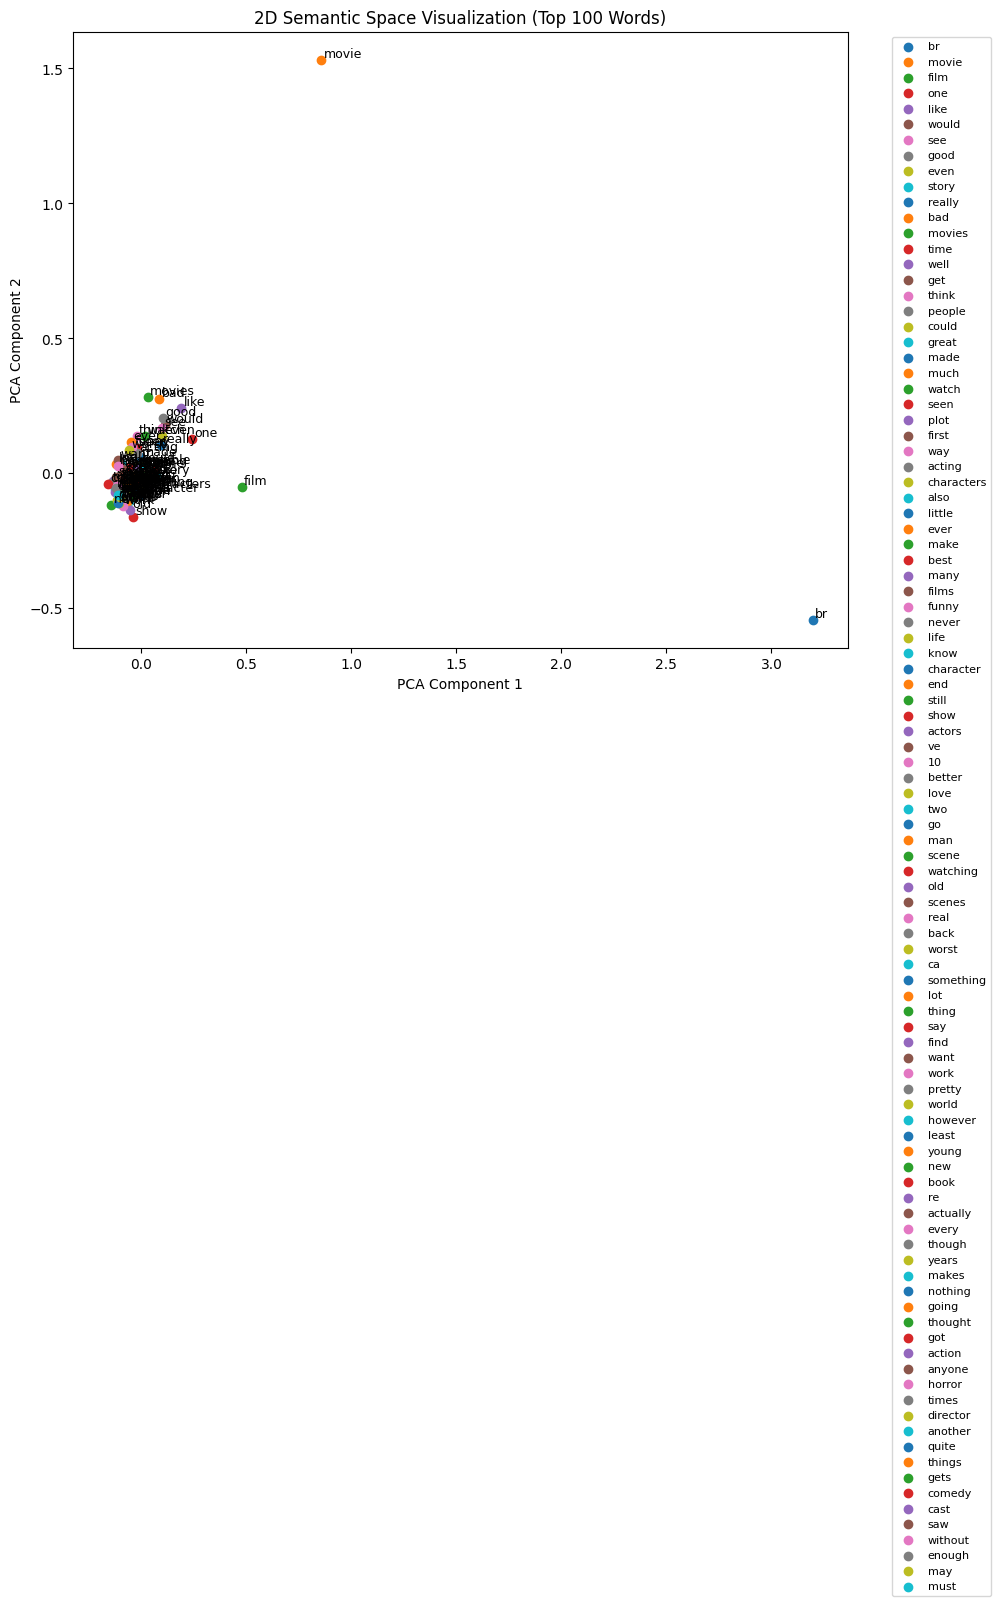

In [ ]:
visualize_similarity(tfidf_matrix, feature_names, top_n=100)